# Query and Stack Imagery into a GIF Using stackstac and Dask

**Attribution**: This tutorial is developed based on the [example](https://stackstac.readthedocs.io/en/latest/examples/gif.html) provided in the stackstac documentation. 

We'll load all the [Landsat-8 (Collection 2, Level 2)](https://planetarycomputer.microsoft.com/dataset/landsat-8-c2-l2) data that's available from [Microsoft's Planetary Computer](https://planetarycomputer.microsoft.com/) over a small region on the coast of [Cape Cod](https://www.google.com/maps/place/Chatham,+MA/@41.7498076,-70.2026227,10.73z/data=!4m13!1m7!3m6!1s0x89fb15440149e94d:0x1f9c0efa001cb20b!2sCape+Cod!3b1!8m2!3d41.6687897!4d-70.2962408!3m4!1s0x89fb142168afbe53:0x714436ec7d485a53!8m2!3d41.6821432!4d-69.9597359), Massachusetts, USA.

Using nothing but standard xarray syntax, we'll mask cloudy pixels with the Landsat QA band and reduce the data down to biannual median composites. We will use Dask to make this much faster. 

[Animated](https://geogif.readthedocs.io/en/latest/) as a GIF, we can watch the coastline move over the years due to [longshore drift](https://en.wikipedia.org/wiki/Longshore_drift).

You can access this notebook (in a Docker image) on this [GitHub repo](https://github.com/HamedAlemo/dask-tutorial).

In [1]:
import dask
import pystac_client
import planetary_computer
import leafmap
import geogif
import stackstac

Start your Dask cluster:

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 5,Total memory: 7.67 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40851,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 5
Started: Just now,Total memory: 7.67 GiB
Comm: tcp://127.0.0.1:45323,Total threads: 1
Dashboard: http://127.0.0.1:39459/status,Memory: 1.53 GiB
Nanny: tcp://127.0.0.1:33483,


Interactively pick the area of interest from a map. Just move the map around and re-run all cells to generate the timeseries somewhere else!

In [3]:
import leafmap

In [4]:
m = leafmap.Map(center=[41.64933994767867, -69.94438630063088], zoom=12, height="800px")
m

Map(center=[41.64933994767867, -69.94438630063088], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [5]:
bbox = (m.west, m.south, m.east, m.north)

## Search for STAC items

Use [pystac-client](https://github.com/stac-utils/pystac-client) to connect to Microsoft's STAC API endpoint and search for Landsat-8 scenes.

In [6]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [7]:
search = catalog.search(
    collections=['landsat-8-c2-l2'],
    bbox=bbox,
)

Load all the STAC items:

In [8]:
items = search.get_all_items()
len(items)

201

These are the footprints of all the items we'll use:

In [9]:
m.add_geojson(items.to_dict(), zoom=12)
m

Map(bottom=391020.0, center=[41.64933994767867, -69.94438630063088], controls=(ZoomControl(options=['position'…

## Create an xarray with stacksatc

Set `bounds_latlon=bbox` to automatically clip to our area of interest (instead of using the full footprints of the scenes).

In [10]:
%%time
stack = stackstac.stack(items, bounds_latlon=bbox)
stack

CPU times: user 104 ms, sys: 4.8 ms, total: 109 ms
Wall time: 106 ms


<xarray.DataArray 'stackstac-0bffcf6778474275db65519a313c614c' (time: 201,
                                                                band: 19,
                                                                y: 768, x: 747)>
dask.array<fetch_raster_window, shape=(201, 19, 768, 747), dtype=float64, chunksize=(1, 1, 768, 747), chunktype=numpy.ndarray>
Coordinates: (12/27)
  * time                         (time) datetime64[ns] 2013-03-22T15:19:00.54...
    id                           (time) <U31 'LC08_L2SP_011031_20130322_02_T1...
  * band                         (band) <U13 'SR_B1' 'SR_B2' ... 'SR_QA_AEROSOL'
  * x                            (x) float64 4.101e+05 4.102e+05 ... 4.325e+05
  * y                            (y) float64 4.623e+06 4.623e+06 ... 4.6e+06
    view:off_nadir               int64 0
    ...                           ...
    title                        (band) <U46 'Coastal/Aerosol Band (B1)' ... ...
    gsd                          (band) float64 30.0 30.0 30.0 ... 30.0 30.0
    common_name                  (band) object 'coastal' 'blue' ... None None
    center_wavelength            (band) object 0.44 0.48 0.56 ... None None None
    full_width_half_max          (band) object 0.02 0.06 0.06 ... None None None
    epsg                         int64 32619
Attributes:
    spec:        RasterSpec(epsg=32619, bounds=(410130.0, 4599750.0, 432540.0...
    crs:         epsg:32619
    transform:   | 30.00, 0.00, 410130.00|\n| 0.00,-30.00, 4622790.00|\n| 0.0...
    resolution:  30.0

And that's it for stackstac! Everything from here on is just standard xarray operations.

Band names are not trivial from the initial query:

In [11]:
stack.band 

<xarray.DataArray 'band' (band: 19)>
array(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ST_QA',
       'ST_B10', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_TRAD', 'ST_URAD',
       'QA_PIXEL', 'ST_ATRAN', 'ST_CDIST', 'QA_RADSAT', 'SR_QA_AEROSOL'],
      dtype='<U13')
Coordinates: (12/16)
  * band                       (band) <U13 'SR_B1' 'SR_B2' ... 'SR_QA_AEROSOL'
    view:off_nadir             int64 0
    instruments                object {'oli', 'tirs'}
    landsat:collection_number  <U2 '02'
    platform                   <U9 'landsat-8'
    description                (band) <U91 'Collection 2 Level-2 Coastal/Aero...
    ...                         ...
    title                      (band) <U46 'Coastal/Aerosol Band (B1)' ... 'A...
    gsd                        (band) float64 30.0 30.0 30.0 ... 30.0 30.0 30.0
    common_name                (band) object 'coastal' 'blue' ... None None
    center_wavelength          (band) object 0.44 0.48 0.56 ... None None None
    full_width_half_max        (band) object 0.02 0.06 0.06 ... None None None
    epsg                       int64 32619

You can replace them using the `common_name` field:

In [12]:
stack = stack.assign_coords(band=stack.common_name.fillna(stack.band).rename("band"))
stack.band

<xarray.DataArray 'band' (band: 19)>
array(['coastal', 'blue', 'green', 'red', 'nir08', 'swir16', 'swir22', 'ST_QA',
       'lwir11', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_TRAD', 'ST_URAD',
       'QA_PIXEL', 'ST_ATRAN', 'ST_CDIST', 'QA_RADSAT', 'SR_QA_AEROSOL'],
      dtype=object)
Coordinates: (12/16)
    view:off_nadir             int64 0
    instruments                object {'oli', 'tirs'}
    landsat:collection_number  <U2 '02'
    platform                   <U9 'landsat-8'
    description                (band) <U91 'Collection 2 Level-2 Coastal/Aero...
    landsat:processing_level   <U4 'L2SP'
    ...                         ...
    gsd                        (band) float64 30.0 30.0 30.0 ... 30.0 30.0 30.0
    common_name                (band) object 'coastal' 'blue' ... None None
    center_wavelength          (band) object 0.44 0.48 0.56 ... None None None
    full_width_half_max        (band) object 0.02 0.06 0.06 ... None None None
    epsg                       int64 32619
  * band                       (band) object 'coastal' ... 'SR_QA_AEROSOL'

See how much input data there is for just RGB. This is the amount of data we'll end up processing

In [13]:
stack.sel(band=["red", "green", "blue"])

<xarray.DataArray 'stackstac-0bffcf6778474275db65519a313c614c' (time: 201,
                                                                band: 3,
                                                                y: 768, x: 747)>
dask.array<getitem, shape=(201, 3, 768, 747), dtype=float64, chunksize=(1, 1, 768, 747), chunktype=numpy.ndarray>
Coordinates: (12/27)
  * time                         (time) datetime64[ns] 2013-03-22T15:19:00.54...
    id                           (time) <U31 'LC08_L2SP_011031_20130322_02_T1...
  * x                            (x) float64 4.101e+05 4.102e+05 ... 4.325e+05
  * y                            (y) float64 4.623e+06 4.623e+06 ... 4.6e+06
    view:off_nadir               int64 0
    instruments                  object {'oli', 'tirs'}
    ...                           ...
    gsd                          (band) float64 30.0 30.0 30.0
    common_name                  (band) object 'red' 'green' 'blue'
    center_wavelength            (band) object 0.65 0.56 0.48
    full_width_half_max          (band) object 0.04 0.06 0.06
    epsg                         int64 32619
  * band                         (band) object 'red' 'green' 'blue'
Attributes:
    spec:        RasterSpec(epsg=32619, bounds=(410130.0, 4599750.0, 432540.0...
    crs:         epsg:32619
    transform:   | 30.00, 0.00, 410130.00|\n| 0.00,-30.00, 4622790.00|\n| 0.0...
    resolution:  30.0

## Mask cloudy pixels using the QA band

Use the bit values of the Landsat-8 QA band to mask out bad pixels. We'll mask pixels labeled as dilated cloud, cirrus, cloud, or cloud shadow. (By "mask", we mean just replacing those pixels with NaNs).

See page 14 on [this PDF](https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/media/files/LSDS-1619_Landsat-8-9-C2-L2-ScienceProductGuide-v4.pdf) for the data table describing which bit means what.

In [14]:
mask_bitfields = [1, 2, 3, 4]  # dilated cloud, cirrus, cloud, cloud shadow
bitmask = 0
for field in mask_bitfields:
    bitmask |= 1 << field

bin(bitmask)

'0b11110'

In [15]:
qa = stack.sel(band="QA_PIXEL").astype("uint16")
mask = qa & bitmask  # just look at those 4 bits

cloud_free_stack = stack.where(mask == 0)  # mask pixels where any one of those bits are set

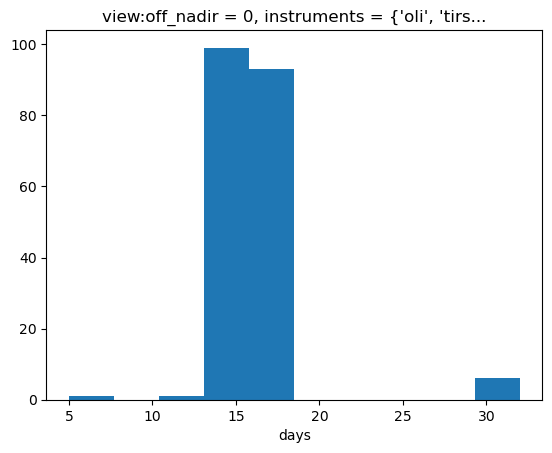

In [16]:
# What's the typical interval between scenes?
cloud_free_stack.time.diff("time").dt.days.plot.hist();

## Make biannual median composites

The Landsat-8 scenes appear to typically be 5-15 days apart. Let's composite that down to a 6-month interval.

Since the cloudy pixels we masked with NaNs will be ignored in the `median`, this should give us a decent cloud-free-ish image for each.

In [17]:
# Make biannual median composites (`2Q` means 2 quarters)
composites_stack = cloud_free_stack.resample(time="2Q").median("time")
composites_stack

<xarray.DataArray 'stackstac-0bffcf6778474275db65519a313c614c' (time: 19,
                                                                band: 19,
                                                                y: 768, x: 747)>
dask.array<stack, shape=(19, 19, 768, 747), dtype=float64, chunksize=(1, 1, 768, 747), chunktype=numpy.ndarray>
Coordinates: (12/13)
  * x                          (x) float64 4.101e+05 4.102e+05 ... 4.325e+05
  * y                          (y) float64 4.623e+06 4.623e+06 ... 4.6e+06
    view:off_nadir             int64 0
    instruments                object {'oli', 'tirs'}
    landsat:collection_number  <U2 '02'
    platform                   <U9 'landsat-8'
    ...                         ...
    proj:epsg                  int64 32619
    landsat:wrs_type           <U1 '2'
    landsat:wrs_row            <U3 '031'
    epsg                       int64 32619
  * band                       (band) object 'coastal' ... 'SR_QA_AEROSOL'
  * time                       (time) datetime64[ns] 2013-03-31 ... 2022-03-31
Attributes:
    spec:        RasterSpec(epsg=32619, bounds=(410130.0, 4599750.0, 432540.0...
    crs:         epsg:32619
    transform:   | 30.00, 0.00, 410130.00|\n| 0.00,-30.00, 4622790.00|\n| 0.0...
    resolution:  30.0

Pick the red-green-blue bands to make a true-color image.

In [18]:
rgb_stack = composites_stack.sel(band=["red", "green", "blue"])
rgb_stack

<xarray.DataArray 'stackstac-0bffcf6778474275db65519a313c614c' (time: 19,
                                                                band: 3,
                                                                y: 768, x: 747)>
dask.array<getitem, shape=(19, 3, 768, 747), dtype=float64, chunksize=(1, 1, 768, 747), chunktype=numpy.ndarray>
Coordinates: (12/13)
  * x                          (x) float64 4.101e+05 4.102e+05 ... 4.325e+05
  * y                          (y) float64 4.623e+06 4.623e+06 ... 4.6e+06
    view:off_nadir             int64 0
    instruments                object {'oli', 'tirs'}
    landsat:collection_number  <U2 '02'
    platform                   <U9 'landsat-8'
    ...                         ...
    proj:epsg                  int64 32619
    landsat:wrs_type           <U1 '2'
    landsat:wrs_row            <U3 '031'
    epsg                       int64 32619
  * band                       (band) object 'red' 'green' 'blue'
  * time                       (time) datetime64[ns] 2013-03-31 ... 2022-03-31
Attributes:
    spec:        RasterSpec(epsg=32619, bounds=(410130.0, 4599750.0, 432540.0...
    crs:         epsg:32619
    transform:   | 30.00, 0.00, 410130.00|\n| 0.00,-30.00, 4622790.00|\n| 0.0...
    resolution:  30.0

Some final cleanup to make a nicer-looking animation:

* Forward-fill any NaN pixels from the previous frame, to make the animation look less jumpy.
* Also skip the first frame, since its NaNs can't be filled from anywhere.

In [19]:
cleaned_stack = rgb_stack.ffill("time")[1:]

## Render the GIF

Use [GeoGIF](https://geogif.readthedocs.io/en/latest/) to turn the stack into an animation. We'll use [dgif](https://geogif.readthedocs.io/en/latest/api.html#dask-dgif) to render the GIF on the cluster, so there's less data to send back. (GIFs are a lot smaller than NumPy arrays!)

In [20]:
%%time
gif_img = geogif.dgif(cleaned_stack).compute()

/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


CPU times: user 27.1 s, sys: 4.75 s, total: 31.8 s
Wall time: 5min 36s


In [21]:
# we turned ~2.6GiB of data into a 2.7MB GIF!
dask.utils.format_bytes(len(gif_img.data))

'2.68 MiB'

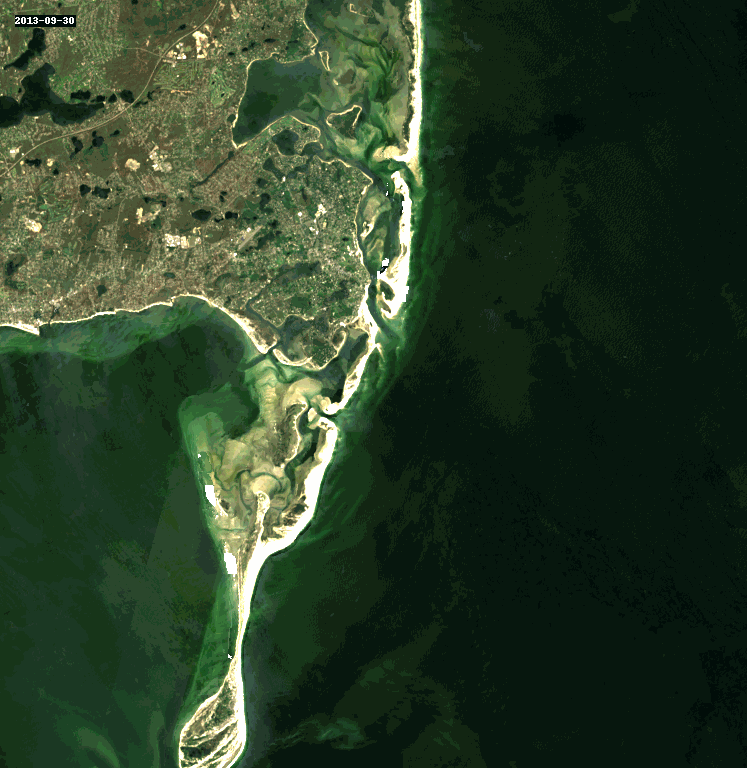

In [22]:
gif_img